# Solve Lunar Lander with DQN

the LL environ- ment is a simulated environment where the agent needs to successfully and safely land the aircraft in the designated area. The lunar lander has 4 discrete actions, do nothing, fire the left orientation engine, fire the main engine, and fire the right orientation engine. The states of the lander are represented as 8-dimensional vectors:
`(x, y, vx, vy, θ, vθ, lef tleg, rightleg)`, 
x and y are the x and y-coordinates of the lunar lander’s position on the screen. vx and vy are the lunar lander’s velocity components on the x and y axes.θ is the angle of the lunar lander. vθ is the angular velocity of the lander. Finally, leftleg and rightleg are binary values to indicate whether the left leg or right leg of the lunar lander is touching the ground. The lunar lander starts as (0,0) and the target landing pad is at (0, 1). The total reward for moving from starting point to landing pad ranges from 100 - 140 points varying on lander placement on the pad. If lander moves away from landing pad it is penalized the amount of reward that would be gained by moving towards the pad. An episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points respectively. Each leg ground contact is rewarded with +10 points. Each firing main engine action has a -0.3 point reward, but fuels are infinite. Lastly, the LL problem is considered solved when an average of 200 points is achieved over 100 consecutive runs.

In [1]:
!pip install box2d-py

     |████████████████████████████████| 450kB 3.5MB/s 


In [0]:
from collections import deque, namedtuple
import time
import math
import copy
import random
import gym
from gym import wrappers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

_ = torch.manual_seed(1027)
np.random.seed(1027)
random.seed(1027)

## Experience Replay

This is the key to train DQN, it serves to remove strong correlations between consecutive transitions because transitions are randomly sampled for training with experience replay.

In [0]:
Experience = namedtuple("Experience", ('state', 'action', 'reward', 'next_state', 'is_done'))

class ExpReplay:
    def __init__(self, capacity=100000, starting_size=20000):
        self.memory = deque(maxlen=capacity)
        self.starting_size = starting_size
        
    def add(self, transition):
            self.memory.append(transition)
            
    def sample(self, batch_size=16):
        if batch_size > len(self.memory):
            return None
        return random.sample(self.memory, batch_size)

    def canStart(self):
        return len(self.memory) >= self.starting_size

## Function Approximation

An artificial neural network (ANN) is used as function approximation.

In [0]:
class QNN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[20, 20]):
        super(QNN, self).__init__()
        self.state_dim = state_dim
        self.n_action = action_dim
        
        n_nodes = [state_dim] + hidden_dims + [action_dim]
        self.layers = nn.ModuleList([])
        for i in range(1, len(n_nodes)):
            self.layers.append(nn.Linear(n_nodes[i-1], n_nodes[i]))
        
    def forward(self, X):
        
        # feed through all layers
        for i in range(len(self.layers) - 1):
            X = torch.tanh(self.layers[i](X))
        
        out = self.layers[-1](X)
        
        return out

In [0]:
# loss function
def loss_fn(yPred, yTrue):
    return torch.nn.SmoothL1Loss()(yPred, yTrue)

## The Lunar Lander Agent

In [0]:
class LunarLanderAgent:
    def __init__(self, env, policy_net, target_net, exp_replay):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.n_action = env.action_space.n
        
        # intialize NN for Q function approximation, and associated target net
        self.pn = policy_net.to(device)               
        self.tn = target_net.to(device)              
        self.tn.load_state_dict(self.pn.state_dict())
        self.tn.eval()
        
        # initialize experience replay
        self.memo = exp_replay   
    
    def __wrapState(self, state):
        """Wrap state tuples into a torch.tensor"""
        return torch.tensor(state, dtype=torch.float32, device=device).reshape(1, -1)
    
    def chooseAction(self, state, epsilon):
        """
        Choose action using the epsilon greedy policy, with epsilon probability to choose a random action, 
        otherwise stick with policy.
        """
        explore = (torch.rand(1) < epsilon)
        if explore:  
            # need to explore
            return torch.randint(0, self.n_action, (1,)).item()
        else:        
            # pick the best move
            state = self.__wrapState(state)
            with torch.no_grad():
                action = self.pn(state).detach().argmax().item()
            return action
        
    def play(self, render=False, sleep_time=0.1):
        '''
        Run the agent in the environment once, return the total reward if no rendering
        is needed, otherwise, render the environment with given time intervals between 
        each frame.
        '''
        total_reward = 0
        state = self.env.reset()
        while True:
            with torch.no_grad():
                action = self.pn(self.__wrapState(state)).argmax().item()
            new_state, reward, done, _ = self.env.step(action)
            if render:
                time.sleep(sleep_time)
                self.env.render()
            total_reward += reward
            state = new_state
            if done:
                break
        if render:
            print("Total reward: %d" % total_reward)
            self.env.close()
        else:
            return total_reward

## Training

The training procedure follows the original algorithm described in Mnih et al. (2015) like below:

![DQN algorithm]('dqnalg.png')

Something different is that an early-stopping flag is added to early stop training when the agent is already able to confidently (90%) land on the landing pad with > 200 points.

In [0]:
def processBatch(batch):
    '''Wrap elements of mini-batches into torch tensors'''
    state_dim = batch[0].state.shape[0]

    X = torch.empty((len(batch), state_dim), dtype=torch.float32)
    X_next = torch.empty((len(batch), state_dim), dtype=torch.float32)
    rewards = torch.empty((len(batch), 1), dtype=torch.float32)
    actions = torch.zeros((len(batch,)), dtype=torch.long)
    not_dones = torch.tensor([True] * len(batch), dtype=torch.bool)
    for i, transition in enumerate(batch):
        X[i, :] = torch.tensor(transition.state, dtype=torch.float32)            # current state
        X_next[i, :] = torch.tensor(transition.next_state, dtype=torch.float32)  # next state
        actions[i] = transition.action                                           # action
        rewards[i, :] = transition.reward                                        # rewards
        not_dones[i] = not transition.is_done                                    # is terminal state
        
    return X.to(device), X_next.to(device), actions.to(device), rewards.to(device), not_dones.to(device)


def train(agent, optimizer, episodes=500, batch_size=32, update_rate=1, gamma=0.99, 
            max_epsilon=1, min_epsilon=0.1, eps_decay=200, reward_thres=195, C=100):
    '''Train the agent'''

    print("Training start:")
    
    # counter of total steps taken
    step_counter = 0   
    
    # record the return from every episode, for diagnose purpose
    episode_return = []
    
    # early stop flag
    early_stop = False
    
    for i in range(episodes):
        state = agent.env.reset()
        reward_rec = 0  # record reward of this episode
        if early_stop:
            break
        while True:
            # decay epsilon
            if agent.memo.canStart():
                # do not decay epsilon when the replay memory is not large enough, instead, use max_epsilon
                epsilon = min_epsilon + (max_epsilon - min_epsilon) * math.exp(-1. * step_counter / eps_decay)
            else:
                epsilon = max_epsilon
                
            action = agent.chooseAction(state, epsilon)
            new_state, reward, done, _ = agent.env.step(action)

            step_counter += 1      # increment the counter of steps taken
            reward_rec += reward   # record the reward of this transition
            
            # new_state = agent.__wrapState(new_state)
            agent.memo.add(Experience(state, action, reward, new_state, done))
            
            # don't forget this assignment!!!!!
            state = new_state
            
            if done:
                episode_return.append(reward_rec)
                if (i+1) % 100 == 0:
                    # print something useful every 100 episodes
                    mean_reward = np.mean(episode_return[-100:]).item()                  # mean reward of the last 100 episodes
                    num_solve = np.sum(np.array(episode_return[-100:]) >= reward_thres)  # count of last 100 episodes that solved
        
                    # early stop if the current policy already solved problem and the exploration rate is low
                    if mean_reward >= reward_thres and num_solve >= 90 and epsilon < min_epsilon + 0.05:
                        early_stop = True

                    print("  -Episode: {0}/{1};\tTotal steps: {2};\tMean rewards of last 100 runs: {3};\t\
                    Count of solved episodes in last 100 runs: {4}"\
                            .format(i+1, episodes, step_counter, mean_reward, num_solve))
                break
            
            
            # check if replay memory is big enough to start learning, learn every update_rate steps
            if not agent.memo.canStart() or step_counter % update_rate != 0:
                continue
            
            # =====================
            # sample from experience memory and start learning
            # =====================
            batch = agent.memo.sample(batch_size=batch_size)
            if batch is None:
                continue
            else:
                # transform batch into predicted and true Q values
                X, X_next, actions, rewards, not_dones = processBatch(batch)
                
                yPred = agent.pn(X).gather(1, actions.view(-1, 1))
                yTrue = torch.zeros((len(batch), 1), dtype=torch.float32, device=device)
                yTrue[not_dones, :] = agent.tn(X_next[not_dones, :]).detach().max(1)[0].view(-1, 1)
                yTrue = rewards + yTrue * gamma
    
                loss = loss_fn(yPred, yTrue)
                
                optimizer.zero_grad()
                loss.backward()
                
#                 for param in agent.pn.parameters():
#                     param.grad.data.clamp_(-1, 1)
                    
                optimizer.step()
            
            if step_counter % C == 0:   # update target network after C steps
                agent.tn.load_state_dict(agent.pn.state_dict())
    
    print("Training complete!")
    plot_training(episode_return)
    return episode_return


def plot_training(episode_rewards, solve_thres=200):

    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        from IPython import display
    
    x_ticks = len(episode_rewards)
    y_max = max(episode_rewards)
    y_min = min(episode_rewards)

    plt.figure(figsize=(4, 3))
    plt.grid(True)
    plt.plot(range(1, x_ticks+1), episode_rewards, c='b', label="episode returns")
    plt.plot(range(1, x_ticks+1), [solve_thres] * x_ticks, c='r', label="solving threshold")
    plt.title("Episode Return during Training")
    plt.legend()
    # plt.savefig("illustrations/training.png", dpi=300)
    plt.show()

def plot_test(agent, solve_thres):
    rewards = []
    for i in range(100):
        rewards.append(agent.play())
    
    num_solved = sum(np.array(rewards) >= solve_thres)

    plt.figure(figsize=(3.54, 2.8))
    plt.grid(True)
    plt.scatter(range(1, 101), rewards, c='b', s=1, label="episode returns")
    plt.plot(range(1, 101), [solve_thres] * 100, c='r', label="Solving threshold")

    plt.title("Episode Return of 100 runs with greedy policy, solved {}/100".format(num_solved))
    plt.legend()
    # plt.savefig("illustrations/test.png", dpi=300)
    plt.show()

## Start Training:

In [0]:
# Hyperparameters
# -----------------------
NUM_EPISODES = 3000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
GAMMA = 0.99
MAX_EPSILON = 1
MIN_EPSILON = 0.05
EPS_DECAY = 50000
EXPERIENCE_CAPACITY = 500000
EXP_START_SIZE = 20000
UPDATE_RATE = 1
REWARD_THRES = 200
C = 10000

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("LunarLander-v2")

# environment attributes 
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# The function approximation for Q function
policy_net = QNN(state_dim, n_actions, [48])
target_net = QNN(state_dim, n_actions, [48])

# Experience replay
exp_play = ExpReplay(EXPERIENCE_CAPACITY, EXP_START_SIZE)

# make the learning agent
agent = LunarLanderAgent(env, policy_net, target_net, exp_play)

# set-up optimizer
optimizer = Adam(agent.pn.parameters(), lr=LEARNING_RATE)

# start training
reward_records = train(agent, optimizer, episodes=NUM_EPISODES, batch_size=BATCH_SIZE, update_rate=UPDATE_RATE, 
            gamma=GAMMA, max_epsilon=MAX_EPSILON, min_epsilon=MIN_EPSILON, eps_decay=EPS_DECAY, reward_thres=REWARD_THRES, C=C)

# save training info
# torch.save(agent.pn.state_dict(), "checkpoint.pt")

Training start:
  -Episode: 100/3000;	Total steps: 8783;	Mean rewards of last 100 runs: -175.4990439516482;	                    Count of solved episodes in last 100 runs: 0
  -Episode: 200/3000;	Total steps: 17829;	Mean rewards of last 100 runs: -187.3332600734228;	                    Count of solved episodes in last 100 runs: 0
  -Episode: 300/3000;	Total steps: 33400;	Mean rewards of last 100 runs: -151.51886581977266;	                    Count of solved episodes in last 100 runs: 0
  -Episode: 400/3000;	Total steps: 69885;	Mean rewards of last 100 runs: -52.62258652746387;	                    Count of solved episodes in last 100 runs: 0
  -Episode: 500/3000;	Total steps: 152415;	Mean rewards of last 100 runs: -54.07681688465758;	                    Count of solved episodes in last 100 runs: 5
  -Episode: 600/3000;	Total steps: 241147;	Mean rewards of last 100 runs: -100.72976795433708;	                    Count of solved episodes in last 100 runs: 0
  -Episode: 700/3000;	Total steps

KeyboardInterrupt: ignored

In [0]:
agent.play(render=False)

Total reward: 221


In [0]:
rewards = 0
for i in range(100):
    rewards += agent.play()

rewards/100

204.6834266441645

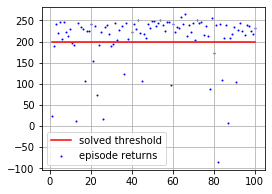

In [0]:
plot_test(agent)

## Trained Agent Performance

![trial](static/ll.gif)